In [4]:
# Required Libraries
import cv2 as cv 
import numpy as np
import os
from matplotlib import pyplot as plt

In [5]:
saltPepperImage = cv.imread('Images/SaltPepperNoise_1.jpg',cv.IMREAD_GRAYSCALE)

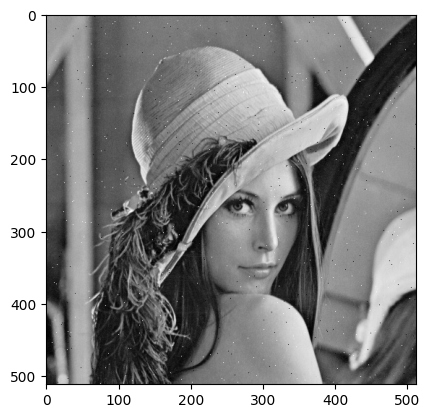

In [6]:
plt.imshow(saltPepperImage,cmap='gray',vmin=0,vmax=255)

We have 3 kernel size 3x3 5x5 7x7

In [29]:
def adaptive_median_filter(image, minFilterSize, maxFilterSize):
    m,n = image.shape
    filteredImage = np.zeros((m,n)).astype(np.uint8)
    max_padded_image = image_padding(image,maxFilterSize)
    for i in range (m):
        for j in range(n):
            filteredImage[i][j]=adaptive_median_filter_single_pixel(max_padded_image,[i,j],minFilterSize,maxFilterSize)
    return filteredImage

def image_padding(image,maxFilterKernel):
    paddingNumber = int(maxFilterKernel/2)
    top_line = image[0]
    bottom_line = image[-1]
    image_upper_padding = image.copy()
    for i in range(paddingNumber):
        image_upper_padding = np.vstack((top_line,image_upper_padding,bottom_line))
    left_line = image_upper_padding[:,0]
    right_line = image_upper_padding[:,-1]
    for i in range(paddingNumber):
        image_upper_padding = np.column_stack((left_line,image_upper_padding,right_line))
    return image_upper_padding

def adaptive_median_filter_single_pixel(image_padded,index_x_y,currKernelSize,maxKernelSize):
    slice = image_padded[index_x_y[0]+int((maxKernelSize-currKernelSize)/2):index_x_y[0]+int((maxKernelSize+currKernelSize)/2),index_x_y[1]+int((maxKernelSize-currKernelSize)/2):index_x_y[1]+int((maxKernelSize+currKernelSize)/2)].flatten()
    slice_sorted = np.sort(slice)
    slice_sorted_med = slice_sorted[int((currKernelSize**2)/2)]
    if np.min(slice_sorted) < slice_sorted_med < np.max(slice_sorted):
        pixel_value = image_padded[index_x_y[0]+int(maxKernelSize/2),index_x_y[1]+int(maxKernelSize/2)]
        if np.min(slice_sorted) < pixel_value < np.max(slice_sorted):
            return pixel_value
        else:
            return slice_sorted_med
    elif currKernelSize+2 == maxKernelSize:
        return slice_sorted_med
    else:
        return adaptive_median_filter_single_pixel(image_padded,index_x_y,currKernelSize+2,maxKernelSize)


In [30]:
filtered_image_result = adaptive_median_filter(saltPepperImage,3,7)

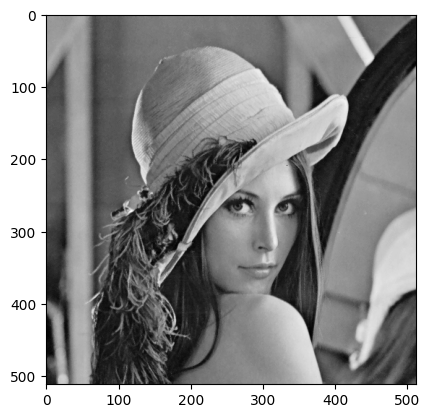

In [31]:
plt.imshow(filtered_image_result,cmap='gray',vmin=0,vmax=255)